In [1]:
# todo: check the model cfg: augmentations, policy

In [1]:
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from utils import parse_cfg, iou_vectorized, objectness_filter_and_nms
from darknet import Darknet

In [2]:
darknet = Darknet('cfg/yolov3_test_todel.cfg')

KeyError: 'type'

In [3]:
weight_file = 'weights/yolov3.weights'
darknet.load_weights(weight_file)
# darknet.eval();

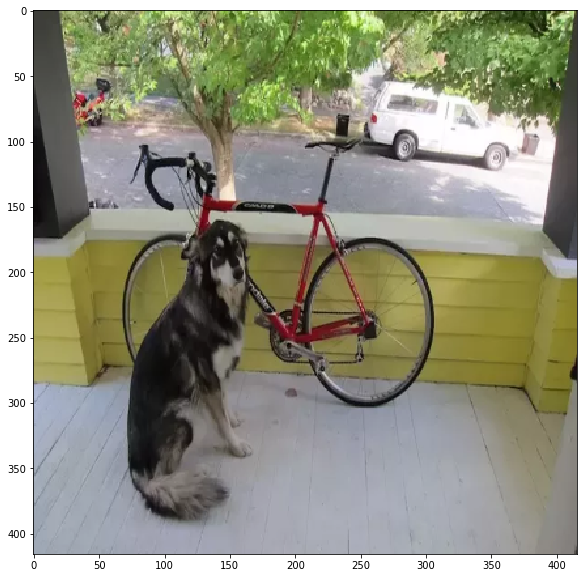

/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor([[123.5162, 272.7216, 103.5570, 216.0370,   1.0000,   0.9944,  16.0000],
        [184.5920, 201.9655, 243.0128, 199.4738,   0.9944,   0.9987,   1.0000],
        [106.1091, 130.3885,  61.6159,  48.8479,   0.8181,   0.9889,   1.0000],
        [315.9732,  91.9115, 111.5049,  50.5905,   1.0000,   0.8376,   7.0000]],
       grad_fn=<CatBackward>)


In [6]:
from matplotlib import pyplot as plt
import cv2

plt.figure(figsize=(10, 10))
# img = cv2.imread('../../../../YOLO_v3_tutorial_from_scratch/det/det_dog-cycle-car.png')
img = cv2.imread('dog-cycle-car.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (416, 416))
plt.imshow(img)
plt.show()
img = img.transpose((2, 0, 1))
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)
pred = darknet.forward(img, torch.device('cpu:0'))
# print('loading tensor')
# pred = torch.load('prediction.pt')
pred = objectness_filter_and_nms(pred, classes=80)
print(pred)

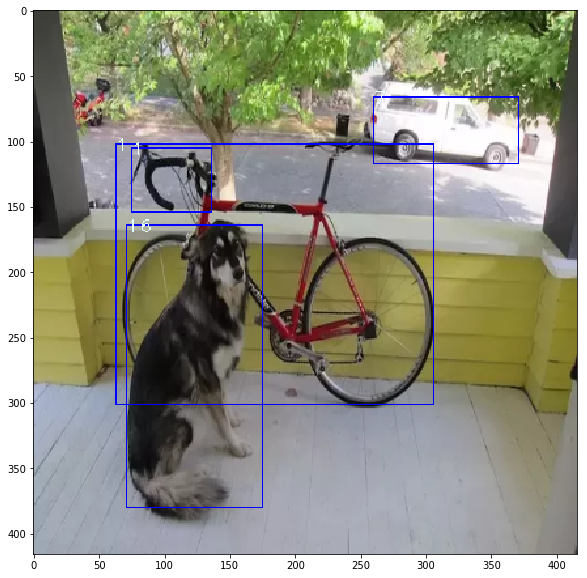

In [7]:
# top_left_x = pred[:, 0] - pred[:, 3]/2
# top_left_y = pred[:, 1] - pred[:, 2]/2
# bottom_right_x = pred[:, 0] + pred[:, 3]/2
# bottom_right_y = pred[:, 1] + pred[:, 2]/2
top_left_x = pred[:, 0] - pred[:, 2]/2
top_left_y = pred[:, 1] - pred[:, 3]/2
bottom_right_x = pred[:, 0] + pred[:, 2]/2
bottom_right_y = pred[:, 1] + pred[:, 3]/2

top_left_x = top_left_x.detach().int().numpy()
top_left_y = top_left_y.detach().int().numpy()
bottom_right_x = bottom_right_x.detach().int().numpy()
bottom_right_y = bottom_right_y.detach().int().numpy()

plt.figure(figsize=(10, 10))
img = cv2.imread('dog-cycle-car.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (416, 416))

for i in range(len(top_left_x)):
#     cv2.rectangle(img, (top_left_y[i], top_left_x[i]), (bottom_right_y[i], bottom_right_x[i]), (0, 0, 255), 1)
    cv2.rectangle(img, (top_left_x[i], top_left_y[i]), (bottom_right_x[i], bottom_right_y[i]), (0, 0, 255), 1)
#     cv2.rectangle(img, (50, 100), (100, 134), (0, 0, 255), 2)
    cv2.putText(img, str(pred[i, 6].detach().int().numpy()), (top_left_x[i], top_left_y[i] + 2 + 4), 
                cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
    
plt.imshow(img)
plt.show()

In [17]:
# todo nms
x = torch.randn((2, 3, 416, 416))
device = torch.device('cpu:0')
predictions = darknet.forward(x, device)
predictions[:, :, 4] *= 1000 # to be removed. just for testing
predictions = pred
objectness_thres = 0.5
nms_thres = 0.4
classes = 80 # darknet.layers_list[-1][0].classes

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])


/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])


In [6]:
bboxes1 = torch.Tensor([(6, 5, 4, 2), (3, 6, 4, 2), (8, 4, 2, 8), (11, 7, 2, 2), (8, 0, 4, 2)]).float()
bboxes2 = bboxes1[0].unsqueeze(0)

iou_vectorized(bboxes1, bboxes2)

tensor([[1.0000],
        [0.0667],
        [0.0909],
        [0.0000],
        [0.0000]])

In [7]:
# Non-max Suppression:
# 1. Filter out predictions with low objectness score
# 2. 
# objectiveness filtering:
# replace all boxes with predicted probability lower than objectness_thres 
# with zeros: calculate 0/1 mask and apply it to the prediction tensor
# Note: '>' returns Byte but '*' needs Float unsqueezed back to 3D
# objectness_mask = (predictions[:, :, 4] > objectness_thres).float().unsqueeze(2)
# predictions = predictions * objectness_mask

# # 


# image_pred = predictions[0]
# image_pred.shape

In [21]:
print('changing predictions in the nms loop make sure that it is not used later')
print('not adding +1')

detections = [None] * len(predictions)

for i, prediction in enumerate(predictions):
#     print(prediction.shape)
    objectness_mask = (prediction[:, 4] > objectness_thres)#.float().unsqueeze(1)
    prediction = prediction[objectness_mask]
    
    # if no object on an image found, continue with the next image
    if prediction.size(0) == 0:
        continue
        
    print(prediction.shape)
    pred_score, pred_classes = torch.max(prediction[:, 5:5+classes], dim=1, keepdim=True)
#     print(pred_classes.shape, pred_score.shape)
    # detections: (cx, cy, w, h, obj_score, top_class_score, top_class_idx)
    prediction = torch.cat((prediction[:, :5], pred_score.float(), pred_classes.float()), dim=1)
#     print(prediction.shape)
    unique_classes = pred_classes.unique().float()
#     print(unique_classes.shape)
    
    detections_after_nms = []
    
    for cls in tqdm(unique_classes):
        prediction_4_cls = prediction[prediction[:, 6] == cls]
        sort_pred_idxs = torch.sort(prediction_4_cls[:, 4], descending=True)[1]
        prediction_4_cls = prediction_4_cls[sort_pred_idxs]          
        
        while len(prediction_4_cls) > 0:
            detections_after_nms.append(prediction_4_cls[0].unsqueeze(0))
            print(prediction_4_cls[0].unsqueeze(0))
            
            if len(prediction_4_cls) == 1:
                break
            
#             print('prediction_4_cls[0, :5].shape, prediction_4_cls[1:, :5].shape')
#             print(prediction_4_cls[0, :5].shape, prediction_4_cls[1:, :5].shape)
            ious = iou_vectorized(prediction_4_cls[0, :5].unsqueeze(0), prediction_4_cls[1:, :5])
            ious = ious.reshape(-1)
#             print(iou.shape)
#             print('iou < nms_thres')
#             print(iou < nms_thres)
#             print(iou.shape)
            prediction_4_cls = prediction_4_cls[1:][ious < nms_thres]
            
        # append to detections

100%|██████████| 4/4 [00:00<00:00, 400.40it/s]

changing predictions in the nms loop make sure that it is not used later
torch.Size([22, 85])
tensor([[100.2575, 378.8981,  16.0283,  29.6745,   0.5537,   0.8899,  58.0000]],
       grad_fn=<UnsqueezeBackward0>)
tensor([[283.3438, 112.5091, 102.9544, 212.8765,   1.0000,   0.9941,  16.0000]],
       grad_fn=<UnsqueezeBackward0>)
tensor([[227.6670, 152.9198, 124.5427, 228.3836,   0.6641,   0.9669,  16.0000]],
       grad_fn=<UnsqueezeBackward0>)
tensor([[216.3377, 169.7828, 241.6037, 196.5571,   0.9946,   0.9987,   1.0000]],
       grad_fn=<UnsqueezeBackward0>)
tensor([[138.1874,  98.4530,  57.0273,  47.3960,   0.8196,   0.9886,   1.0000]],
       grad_fn=<UnsqueezeBackward0>)
tensor([[121.8628, 110.2799,  57.4041,  44.0426,   0.7489,   0.9876,   1.0000]],
       grad_fn=<UnsqueezeBackward0>)
tensor([[240.0890, 207.0442, 364.6438, 333.7238,   0.5685,   0.8301,   1.0000]],
       grad_fn=<UnsqueezeBackward0>)
tensor([[ 92.0773, 315.9416, 114.3170,  49.7113,   0.9999,   0.8397,   7.0000]],

In [26]:
torch.cat(detections_after_nms).shape

torch.Size([10, 7])

In [5]:
sum(p.numel() for p in darknet.parameters() if p.requires_grad)

61949149

In [22]:
bn.runn.data

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
nn.BatchNorm2d()